<a href="https://colab.research.google.com/github/Ananassio/MA/blob/main/PH_fuer_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pyswarms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 1.1 MB/s eta 0:00:00


# Defines

In [6]:
import sympy as sym
from IPython.display import display, Math
from sympy import Symbol, latex


class Combine:
    """Diese Klasse dient dazu zwei Subsysteme symbolisch miteinander zu koppeln, mit Gyrator oder Transformator, !Der Transformator funktioniert nur, für mechanische Systeme und wenn die flows in der Reihenfolge p_punkt, q_punkt angelegt wurden! des Weiteren werden die beiden Massen zusammen gefügt, dabei verbleibt nur die Masse aus Subsystem 1!"""
    temp_g1 = 0
    temp_g2 = 0
    temp_u1 = 0
    temp_u2 = 0
    def __init__(self, Subsystem1, Subsystem2, indexS1, indexS2, Multiplier,CombiningMethod = 'Gyrator', Transform_State=None, Transform_index= None):
        """Args:
        Subsystem1 (Subsystem): Das Port-Hamilton System1 das mit Port-Hamilton System2 verbunden werden soll
        Subsystem2 (Subsystem): Das Port-Hamilton System2 das mit Port-Hamilton System1 verbunden werden soll
        indexS1 (int): (nur Gyrator) Der index des Ein- bzw. Ausgangs des ersten System
        indexS2 (int): Der index des Ein- bzw. Ausgangs des zweiten System
        Multiplier (Symbol): der Multiplikative kopplungsfaktor zwischen den Systemen
        CombiningMethod (String): default='Gyrator', 'Transformator', Transformator ist nur für zwei mechanische Systeme angelegt
        Transform_State (Tuple): Nur für Transformator, hier werden die States der Subsysteme übergeben welche transformiert werden sollen, sowiedas symbol für die zwei neuen States in der Form (S1_p, S1_q, S2_p, S2_q, S_p, S_q) in der Folge Subsystem 1, Subsystem 2 und das resultierende System
        Transform_index (array): Nur für Transformator, hier werden die indexe der beiden Subsysteme übergeben von den Stellen [S1_p, S1_q,S2_p, S2_q]"""
        if CombiningMethod == 'Transformator':
            print('Transformator')

            # extrahieren der kopplungsanteile der J Matrix
            temp_row_J = sym.Matrix([[Subsystem2.J.row(Transform_index[2])],   [Subsystem2.J.row(Transform_index[3])]])
            temp_row_J.col_del(Transform_index[3])
            temp_row_J.col_del(Transform_index[2])
            temp_col_J = sym.Matrix([[Subsystem2.J.col(Transform_index[2]), Subsystem2.J.col(Transform_index[3])]])
            temp_col_J.row_del(Transform_index[3])
            temp_col_J.row_del(Transform_index[2])
            # extrahieren der kopplungsanteile der R Matrix
            temp_row_R = sym.Matrix([[Subsystem2.R.row(Transform_index[2])],   [Subsystem2.R.row(Transform_index[3])]])
            temp_row_R.col_del(Transform_index[3])
            temp_row_R.col_del(Transform_index[2])
            temp_col_R = sym.Matrix([[Subsystem2.R.col(Transform_index[2]), Subsystem2.R.col(Transform_index[3])]])
            temp_col_R.row_del(Transform_index[3])
            temp_col_R.row_del(Transform_index[2])
            # entfernen des zu Combinierenden Teils der J Matrix
            temp_J2 = Subsystem2.J.copy()
            temp_J2.row_del(Transform_index[3])
            temp_J2.row_del(Transform_index[2])
            temp_J2.col_del(Transform_index[3])
            temp_J2.col_del(Transform_index[2])
            # entfernen des zu Cominierenden Teils der R Matrix
            temp_R2 = Subsystem2.R.copy()
            temp_R2.row_del(Transform_index[3])
            temp_R2.row_del(Transform_index[2])
            temp_R2.col_del(Transform_index[3])
            temp_R2.col_del(Transform_index[2])

            # Zusammenfügen der neuen J Matrix
            #Wenn die Systeme die gleiche Dimension haben
            if sym.shape(Subsystem1.J)[0] == 2 and sym.shape(Subsystem2.J)[0] == 2:
                self.J = Subsystem1.J.copy()

            elif sym.shape(Subsystem1.J)[0] > 2:  # Wenn das erste Subsystem größer 2x2 ist müssen die temp row und temp col vektoren mit entsprechenden 0 Vektoren erweitert werden damit die Dimensionen stimmen
                '''temp_row_J = sym.Matrix([[temp_row_J], [sym.zeros(sym.shape(Subsystem1.J)[0]-2, sym.shape(temp_row_J)[1] )]])
                temp_col_J = sym.Matrix([[temp_col_J, sym.zeros(sym.shape(temp_col_J)[0], sym.shape(Subsystem1.J)[1]-2 )]])
                self.J = sym.Matrix([[Subsystem1.J,
                         temp_row_J],
                         [temp_col_J,
                          temp_J2]])'''
                self.J = sym.diag(Subsystem1.J, temp_J2)


                temp_row_J = sym.Matrix([[sym.zeros(2,sym.shape(Subsystem1.J)[0]), temp_row_J ]])
                temp_col_J = sym.Matrix([[sym.zeros(sym.shape(Subsystem1.J)[1],2)], [temp_col_J ]])


                temp_J = sym.zeros(sym.shape(self.J)[0])

                for g_zahl in range(temp_row_J.shape[0]):
                    for i_zahl in range(temp_row_J.shape[1]):
                        temp_J[Transform_index[0] + g_zahl, i_zahl] = temp_row_J[ g_zahl,i_zahl]

                for g_zahl in range(temp_col_J.shape[1]):
                    for i_zahl in range(temp_col_J.shape[0]):
                        temp_J[i_zahl, Transform_index[0] + g_zahl] = temp_col_J[i_zahl, g_zahl]

                self.J = self.J + temp_J
            else:
                self.J = sym.Matrix([[Subsystem1.J,
                         temp_row_J],
                         [temp_col_J,
                          temp_J2]])

            # Zusammenfügen der neuen R Matrix dabei müssen die beiden zu kombinierenden Untersysteme addiert werden
            #Wenn die Systeme die gleiche Dimension haben
            if sym.shape(Subsystem1.R)[0] == 2 and sym.shape(Subsystem2.R)[0] ==2:
                self.R = Subsystem1.R + Subsystem2.R

            elif sym.shape(Subsystem1.R)[0] > 2:  # Wenn das erste Subsystem größer 2x2 ist müssen die temp row und temp col vektoren mit entsprechenden 0 Vektoren erweitert werden damit die Dimensionen stimmen
                '''temp_row_R = sym.Matrix([[temp_row_R], [sym.zeros(sym.shape(Subsystem1.R)[0]-2, sym.shape(temp_row_R)[1] )]])
                temp_col_R = sym.Matrix([[temp_col_R, sym.zeros(sym.shape(temp_col_R)[0], sym.shape(Subsystem1.R)[1]-2 )]])
                self.R = sym.Matrix([[Subsystem1.R ,
                            temp_row_R],
                            [temp_col_R,
                            temp_R2]])'''

                self.R = sym.diag(Subsystem1.R, temp_R2)
                self.R[Transform_index[0],Transform_index[0]] = self.R[[Transform_index[0],Transform_index[1]],[Transform_index[0],Transform_index[1]]] + Subsystem2.R[[Transform_index[2],Transform_index[3]],[Transform_index[2],Transform_index[3]]]

                temp_R = sym.zeros(sym.shape(self.R)[0], sym.shape(self.R)[1])
                temp_row_R = sym.Matrix([[sym.zeros(2,sym.shape(Subsystem1.R)[0]), temp_row_R ]])
                temp_col_R = sym.Matrix([[sym.zeros(sym.shape(Subsystem1.R)[1],2)], [temp_col_R ]])

                temp_R = sym.zeros(sym.shape(self.R)[0])

                for g_zahl in range(temp_row_R.shape[0]):
                    for i_zahl in range(temp_row_R.shape[1]):
                        temp_R[Transform_index[0]+g_zahl, i_zahl] = temp_row_R[ g_zahl,i_zahl]

                for g_zahl in range(temp_col_R.shape[1]):
                    for i_zahl in range(temp_col_R.shape[0]):
                        temp_R[i_zahl, Transform_index[0]+g_zahl] = temp_col_R[i_zahl, g_zahl]

                self.R = self.R + temp_R

            else:
                self.R = sym.Matrix([[Subsystem1.R + Subsystem2.R[[Transform_index[2],Transform_index[3]],[Transform_index[2],Transform_index[3]]],
                            temp_row_R],
                            [temp_col_R,
                            temp_R2]])
            #   ---   State   ---
            # einfügen der neuen Variablen in die States von Subsystem 1
            temp_State1 = list(Subsystem1.State)
            temp_State1[Transform_index[0]] = Transform_State[4]
            temp_State1[Transform_index[1]] = Transform_State[5]
            temp_State1 = tuple(temp_State1)
            # entfernen der zu kombinierenden States aus Subsystem 2
            temp_State2 = list(Subsystem2.State)
            temp_State2.remove(Transform_State[2])
            temp_State2.remove(Transform_State[3])
            temp_State2 = tuple(temp_State2)

            self.State = temp_State1 + temp_State2

            #   ---   Effort   ---
            # zusammensetzen der neuen Energiegleichung, dabei wird S2_p nicht substuiert,
            temp_Energy = Subsystem1.Energy + Subsystem2.Energy
            temp_Energy = temp_Energy.subs({Transform_State[0]:Transform_State[4],
                                            Transform_State[1]:Transform_State[5],
                                            Transform_State[2]: 0,  # dieser State wird mit 0 substituiert, da zwei Massen zusammengefügt werden und somit dieser Ausdruck entfällt
                                            Transform_State[3]:Transform_State[5]})
            self.Energy = temp_Energy
            print(self.Energy)
            print(self.State)
            # erstellen des effor Vektors auf Basis der Hamilton-Gleichung
            self.dhdx = sym.Matrix(sym.derive_by_array(self.Energy,self.State))


            # Vektoren g
            temp_g1 = Subsystem1.g.copy()
            temp_g2 = Subsystem2.g.copy()

            '''del temp_g1[indexS1] #entfernen der g´s für die Verbindung
            del temp_g2[indexS2]'''

            temp_g = list(map(lambda v: v.row_insert(sym.shape(Subsystem1.g[0])[0], sym.zeros(len(Subsystem2.g[0])-2,1)), temp_g1)) + list(map(lambda v: v.row_insert(0, sym.zeros(len(Subsystem1.g[0])-2,1)), temp_g2))


            for i in range(len(temp_g)):
                print(i)
                # Wert von p2 an die neue Stelle schreiben p1
                # prüfen ob an dem "alten Eingang" ein Eintrag ist, da die "alten" zwei Zeilen entfernt wurden muss bei dem index -2 gemacht werden um die Eingänge des 2 Subsystems zu finden
                if temp_g[i][Transform_index[2] + len(Subsystem1.g[0]) - 2] != 0:
                    # falls ja, Wert an temporäre Variable übergeben
                    temp2 = temp_g[i][Transform_index[2] + len(Subsystem1.g[0]) - 2]
                    # Eintrag zu Null setzen
                    temp_g[i][Transform_index[2] + len(Subsystem1.g[0]) - 2] = 0
                    # Wert an die "neue Masse" setzen
                    temp_g[i][Transform_index[0]] = temp2
                    print(i)

                # Wert von q2 an die neue Stelle schreiben q1
                if temp_g[i][Transform_index[3] + len(Subsystem1.g[0]) - 2] != 0:
                    temp2 = temp_g[i][Transform_index[3] + len(Subsystem1.g[0]) - 2]
                    temp_g[i][Transform_index[3] + len(Subsystem1.g[0]) - 2] = 0
                    temp_g[i][Transform_index[1]] = temp2

            self.g = temp_g


            # Vektoren u
            temp_u1 = Subsystem1.u.copy()
            temp_u2 = Subsystem2.u.copy()
            '''temp_u1.row_del(indexS1)
            temp_u2.row_del(indexS2)'''
            self.u = sym.Matrix(temp_u1).row_insert(sym.shape(temp_u1)[0], sym.Matrix(temp_u2))

            # Ausgänge y
            self.y = sym.zeros(len(self.g),1)
            for i in range(len(self.g)):
                self.y[i] = (self.g[i].T * self.dhdx)


        else: # Gyrator
            print('Gyrator')
            # Matrix J
            self.J = sym.Matrix([[Subsystem1.J,
                         (Subsystem1.g[indexS1]*Subsystem2.g[indexS2].T)*Multiplier],
                         [(-Subsystem2.g[indexS2]*Subsystem1.g[indexS1].T)*Multiplier,
                          Subsystem2.J]])
            # Matrix R
            self.R = sym.diag(Subsystem1.R,Subsystem2.R)
            # Energie, State und effort
            self.Energy = Subsystem1.Energy + Subsystem2.Energy
            self.State = Subsystem1.State + Subsystem2.State
            # erstellen des effor Vektors auf Basis der Hamilton-Gleichung
            self.dhdx = sym.Matrix(sym.derive_by_array(self.Energy,self.State))

            # Vektoren g
            temp_g1 = Subsystem1.g.copy()
            temp_g2 = Subsystem2.g.copy()

            del temp_g1[indexS1] #entfernen der g´s für die Verbindung
            del temp_g2[indexS2]

            self.g = list(map(lambda v: v.row_insert(sym.shape(Subsystem1.g[0])[0], sym.zeros(len(Subsystem2.g[0]),1)), temp_g1)) + list(map(lambda v: v.row_insert(0, sym.zeros(len(Subsystem1.g[0]),1)), temp_g2))

            # Vektoren u
            temp_u1 = Subsystem1.u.copy()
            temp_u2 = Subsystem2.u.copy()
            temp_u1.row_del(indexS1)
            temp_u2.row_del(indexS2)
            self.u = sym.Matrix(temp_u1).row_insert(sym.shape(temp_u1)[0], sym.Matrix(temp_u2))

            # Ausgänge y
            self.y = sym.zeros(len(self.g),1)
            for i in range(len(self.g)):
                self.y[i] = (self.g[i].T * self.dhdx)


    def show(self):
        x_dot = r'\begin{bmatrix} ' + r'\\ '.join('\dot{' + latex(sym) + '}' for sym in self.State) + r'\end{bmatrix}'

        temp = x_dot + ' = '+"("+latex(self.J) +"-" +latex(self.R) +")"+latex(self.dhdx)
        for i in range(sym.shape(self.u)[0]):
            temp = temp + latex('+') + latex(self.g[i]) + latex(self.u[i])
        display(Math( temp))
        for i in range(sym.shape(self.u)[0]):
            display(Math('y_'+latex(i)+'=' + latex(self.g[i].T) + latex(self.dhdx)))


In [7]:
#--------------------------------------------------
# Berechnen eines Systems
import sympy as sym
import numpy as np
from scipy import signal
from scipy.integrate import solve_ivp
from sympy import Symbol
t = Symbol('t')
z = Symbol('z')
import matplotlib.pyplot as plt

def Simulate(System, konst, Input_Symbol, Input_Signal, Initial_conditions,t_span,eval=None,fun_dependency=None,solver='RK45'):
    '''Args:
    System (System): Port-Hamilton System das simuliert werden soll
    konst (dict): ein dictionary mit den Symbolen der konstanten und den Zahlenwerten mit denen sie ersetzt werden sollen
    Input_Symbol (tuple): Ein Tuple mit den Eingangssymbolenz.B. (I,) oder (F1, F2)
    Input_Signal (func): Das eingangssignal für das zugehörige Eingangssymbol
    Initial_condition(array): Ein Array mit den inertialwerten der Zustände, Reihenfolge der Zustände kann mit System.State geprüft werden
    t_span (tuple): Zu simulierende Zeitspanne, z.B. (0,10) -> von 0 bis 10 sekunden (solve_ivp Parameter)
    t_eval (array_like): Die Zeiten an denen die Messpunkte gespeichert werden sollen z.B. (0,10,100) (solve_ivp Parameter)
    fun_dependency (Array of Array): Für Zustandsabhängige Variablen, [[Funktion,Symbol zu ersetzen, Symbol der Abhängigkeit],[...]]; für einzelne [[f,s1,s2]]
    solver (string): der Solver der für das Lösen verwendet werden soll, siehe doku scipy solvve_ivp method'''
    #ausmultiplizieren der einzelnen Systemelemente
    res = (System.J - System.R)*System.dhdx

    for i in range(sym.shape(System.u)[0]):
        res = res + System.g[i] * System.u[i]



       # Substituiren eines Ausdruckes mit einer Zustandsabhängigen Funktion
    if fun_dependency:
        for i in range(len(fun_dependency)):
            res = res.subs(fun_dependency[i][1], fun_dependency[i][0](fun_dependency[i][2]))

    # Substituieren der Konstanten
    # z.B. mit konst = {"d":2,"m":1, "k":2,"L": 1, "C": 2, "R": 120, "alpha_1": 1}
    res = res.subs(konst)
    #--------------------------
    # neu
    res =sym.simplify(res)
    # -------------------------
    # extrahieren der einzelnen DGLs
    sys_eq = [sym.Eq(sym.Derivative(var, t), expr) for var, expr in zip(sym.Matrix(System.State+Input_Symbol), res)]

    # konvertieren der symbolischen Gleichungen in Funktionen
    sys_eq_func = [sym.lambdify((t,)+System.State+Input_Symbol, eq.rhs, 'numpy') for eq in sys_eq]

    # dynamische festlegung der Eingangssignale

    def input_signals(t):

        return np.array([signal(t) for signal in Input_Signal])

    if eval:
        evl=np.linspace(eval[0], eval[1], eval[2])
    else:
        evl=None

    # Numerische Integration mit solve_ivp
    solution = solve_ivp(
        lambda t, y: [func(t, *y, *input_signals(t)) for func in sys_eq_func],
        t_span,
        Initial_conditions, #Anfangswerte
        t_eval=evl,
        method=solver
    )

    return solution
#--------------------------------------------------------------------------------------

def Plot(solution, label_solution, Input_Signal, label_input, y_label, x_label='Zeit t'):
    # Darstellung der Ergebnisse
    for i in range(len(solution.y)):
        plt.plot(solution.t, solution.y[i], label=label_solution[i])

    for i in range(len(Input_Signal)):
        plt.plot(solution.t, Input_Signal[i](solution.t), label=label_input[i])

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid()
    plt.legend()
    plt.show()



In [8]:
from sympy import Symbol, latex
from IPython.display import display, Math
import sympy as sym

class Subsystem:
    """Mit dieser Klasse kann dynamisch ein Port-Hamilton Sysrem angelegt werden.
       Das System wird in diesem Fall Symbolisch angelegt, um einfach damit weiter rechnen zu können
    """
    Energy = 0
    State = 0
    def __init__(self ,dim ,num_ports ,S ,E ):
        """Args:
        dim (int): Die Dimensionen, welche das PH-System haben soll
        num_ports (int): Anzahl der Ein- und Ausgänge des Systems
        S (symbole): Die Zustände des Systems
        E (Gleichung mit Symbolen): Die Energiegleichung/Hamiltongleichung des Systems"""

        self.portnum = num_ports
        self.J = sym.zeros(dim)   # erstellen der j Matrix dim x dim
        self.R = sym.zeros(dim)   # erstellen der R Matrix dim x dim

        self._dhdx = sym.Matrix(sym.derive_by_array(E,S)) # erstellen des effor Vektors auf Basis der Hamilton-Gleichung
        self._g = [sym.zeros(dim, 1) for _ in range(num_ports)]
        self._u = sym.zeros(num_ports,1)
        self._y = sym.zeros(num_ports,1)

        self.Energy = E
        self.State = S

    @property
    def g(self):
        for i in range(len(self._g)):

            self._y[i] = (self._g[i].T.dot(self._dhdx)).doit()
        return self._g

    @g.setter
    def g(self, new_values):
        for i in range(len(self._g)):
            self._g[i] = new_values[i].copy()  # Kopie erstellen

            self._y[i] = (self._g[i].T.dot(self._dhdx)).doit() # erstellen von y

    @property
    def u(self):
        return self._u

    @u.setter
    def u(self, new_values):
        for i in range(len(self._u)):
            self._u[i] = new_values[i].copy()  # Kopie erstellen

    @property
    def y(self):
        return self._y

    @property
    def dhdx(self):
        return self._dhdx

    def show(self):
        x_dot = r'\begin{bmatrix} ' + r'\\ '.join('\dot{' + latex(sym) + '}' for sym in self.State) + r'\end{bmatrix}'

        temp = x_dot + ' = '+"("+latex(self.J) +"-" +latex(self.R) +")"+latex(self.dhdx)
        for i in range(self.portnum):
            temp = temp + latex('+') + latex(self.g[i]) + latex(self.u[i])
        display(Math( temp))
        for i in range(self.portnum):
            display(Math('y_'+latex(i)+'=' + latex(self.g[i].T) + latex(self.dhdx)))


In [9]:
import numpy as np
import sympy as sym
from scipy import signal
from scipy.integrate import solve_ivp
from IPython.display import display, Math
from sympy import Symbol, latex, symbols
import matplotlib.pyplot as plt
from math import exp
import plotly.graph_objects as go



#---------------------------------------------------------------------------------------------
# definieren der verwendeten Symbole

# definieren der Symbole des elektrischen Subsystems
Q,phi,C,L,R,I,U_G1,U_G2 = symbols('Q phi C L R I U_G1 U_G2')
konst_EL = {"L": 10e-8, "C": 2e-10, "R": 120}

# definieren der Symbole des mechanischen Subsystems
p,m,q,k,F,d,F_Mag, F_Hydr = symbols('p m q k F d F_Mag F_Hydr')
konst_M1 = {'d':25, 'k':1000, "m":0.2,}

# definieren der Symbole des 2 mechanischen Subsystems
p1_m2,p2_m2,mf_m2,m_m2,q1_m2,q2_m2,k1_m2,k2_m2,d1_m2,d2_m2,dv_m2,F_Mag_m2, F_Hydr_m2 = symbols('p1_m2 p2_m2 mf_m2 m_m2 q1_m2 q2_m2 k1_m2 k2_m2 d1_m2 d2_m2 dv_m2 F_Mag_m2 F_Hydr_m2')
konst_M2 = {'mf_m2':0.000001, 'm_m2':1, 'k1_m2': 2000, 'k2_m2':2000, 'd1_m2': 20,'d2_m2':20, 'dv_m2':10}

# definieren der Symbole des 3 mechanischen Subsystems
p1_m3,p2_m3,p3_m3,mf1_m3, mf2_m3,m_m3,q1_m3,q2_m3,q3_m3,k11_m3,k12_m3,k21_m3,k22_m3,d11_m3,d12_m3,d21_m3,d22_m3,dv1_m3,dv2_m3,F_Mag_m3, F_Hydr_m3 = symbols('p1_m3 p2_m3 p3_m3 mf1_m3 mf2_m3 m_m3 q1_m3 q2_m3 q3_m3 k11_m3 k12_m3 k21_m3 k22_m3 d11_m3 d12_m3 d21_m3 d22_m3 dv1_m3 dv2_m3 F_Mag_m3 F_Hydr_m3')
konst_M3 = {'mf1_m3':0.000001, 'mf2_m3': 0.000001,'m_m3':0.2, 'k11_m3': 1000, 'k12_m3': 1000, 'k21_m3': 1000, 'k22_m3': 1000, 'd11_m3': 100, 'd12_m3': 100, 'd21_m3': 100, 'd22_m3': 100, 'dv1_m3': 50, 'dv2_m3': 50}

# definieren der Symbole des hysterese Subsystems
Q_H1, Q_H2, C_H1, C_H2, R_Hyst1, R_Hyst2, U_GH = symbols('Q_H1 Q_H2 C_H1 C_H2 R_Hyst1 R_Hyst2 U_GH')
konst_hyst = {'C_H1':2e-9, 'C_H2':1e-9}

# definieren der Symbole des alternativen elektrischen Subsystems
phi_E, L_E, R_E, I_E, U_EG1, U_EG2 = symbols('phi_E L_E R_E I_E U_EG1 U_EG2')
konst_ELA = {'L_E': 3e-5,  "R_E": 12}

# definieren der Symbole des ersten Reibmodel Subsystem
p_r1, m_r1, k_r1, q_r1, q_r2, p_r2, m_r2, d_r1, F_r1_int, F_r1_ext, d_r1_var1, d_r1_var2, beta_r1, F_N_r1, mu_0_r1, g_r1_in1, g_r1_in2= symbols('p_r1 m_r1 k_r1 q_r1 q_r2 p_r2 m_r2 d_r1 F_r1_int F_r1_ext d_r1_var1 d_r1_var2 beta_r1 F_N_r1 mu_0_r1 g_r1_in1 g_r1_in2')
konst_R1 = {'F_N_r1': 9.81*0.2, 'beta_r1': 25, 'mu_0_r1': 0.2, 'd_r1':30, 'm_r1': 0.00001, 'm_r2': 0.00001, 'k_r1':20}

# definieren der Symbole des zweiten Reibmodel Subsystem
p1_r2,p2_r2,p3_r2, m1_r2,m2_r2,m3_r2, k1_r2,k2_r2, k3_r2, q1_r2, q2_r2,q3_r2, d2_r2, d3_r2, F_r2_ext = symbols('p1_r2 p2_r2 p3_r2 m1_r2 m2_r2 m3_r2 k1_r2 k2_r2 k3_r2 q1_r2 q2_r2 q3_r2 d2_r2 d3_r2 F_r2_ext')
konst_R2 = {'m1_r2': 0.2, 'm2_r2': 0.01, 'm3_r2': 0.01, 'k1_r2': 1500, 'k2_r2': 5500, 'k3_r2': 1250}

# definieren der Symbole des dritten Reibmodel Subsystem
p_r3, q_r3, m_r3, F_Test_r3, k_r3, d_r3 = symbols('p_r3 q_r3 m_r3 F_Test_r3 k_r3 d_r3')
konst_R3 = {'k_r3': 500, 'd_r3': 20, 'm_r3': 0.2}

# definieren der Symbole des hydraulischen Subsystems
I_H, Gamma_H, R_Hydr1, R_Hydr2, pi_G_H, Delta_pi = symbols('I_H Gamma_H R_Hydr1 R_Hydr2  pi_G_H Delta_pi')
temp_IH = 0.95
konst_H = {'I_H': temp_IH}


#---------------------------------------------------------------------------------------------
# initialisierungsfunktionen der Subsysteme
def Init_Electric_Subsystem():


    # definieren der Energiegleichung und Zustände
    E_EL = 1/2 * Q**2/C + 1/2 * phi**2/L
    S_EL = (Q,phi)

    # anlegen eines Port-hamilton Systems
    SysEl = Subsystem(2,3,S_EL,E_EL)
    SysEl.g = [sym.Matrix([[-1], [-R]]), sym.Matrix([[0], [-1]]), sym.Matrix([[0], [-1]])]

    # Befüllen der Matrizen
    SysEl.J[0,1] = -1
    SysEl.J[1,0] = 1
    SysEl.R[1,1] = R
    SysEl.u[0] = I_E
    SysEl.u[1] = U_G1
    SysEl.u[2] = U_G2

    # Ausgabe des PH-Systems
    print('Electrical system')
    SysEl.show()
    return SysEl

def Init_Mechanical_Subsystem():


    # definieren der Energiegleichung und Zustände
    E_Mech = 1/2 * p**2/m + 1/2 * k*q**2
    S_Mech = (p,q)

    # anlegen eines Port-hamilton Systems
    SysMech = Subsystem(2,2,S_Mech,E_Mech)
    SysMech.g = [sym.Matrix([[-1], [0]]), sym.Matrix([[-1], [0]])]

    # Befüllen der Matrizen
    SysMech.J[0,1] = -1
    SysMech.J[1,0] = 1
    SysMech.R[0,0] = d
    SysMech.u[0] = F_Mag
    SysMech.u[1] = F_Hydr

    # Ausgabe des PH-Systems
    print('Mechanical system')
    SysMech.show()
    return SysMech

def Init_Mechanical_Subsystem_ReibungNurDaempfer():


    # definieren der Energiegleichung und Zustände
    E_Mech = 1/2 * p**2/m
    S_Mech = (p,)

    # anlegen eines Port-hamilton Systems
    SysMech = Subsystem(1,1,S_Mech,E_Mech)
    SysMech.g = [sym.Matrix([[-1]])]

    # Befüllen der Matrizen
    SysMech.J[0,0] = 0
    SysMech.R[0,0] = d
    SysMech.u[0] = F_Mag

    # Ausgabe des PH-Systems
    SysMech.show()
    return SysMech

def Init_Mechanical_Subsystem2():


    # definieren der Energiegleichung und Zustände
    E_Mech2 = 1/2 * p1_m2**2/mf_m2 + 1/2 * k1_m2*q1_m2**2 + 1/2*p2_m2**2/m_m2 + 1/2*k2_m2*(q2_m2-q1_m2)**2
    S_Mech2 = (p1_m2,q1_m2,p2_m2,q2_m2)

    # anlegen eines Port-hamilton Systems
    SysMech2 = Subsystem(4,2,S_Mech2,E_Mech2)
    SysMech2.g = [sym.Matrix([[0], [0],[-1], [0]]), sym.Matrix([[0], [0],[-1], [0]])]

    # Befüllen der Matrizen
    SysMech2.J[0,1] = -1
    SysMech2.J[1,0] = 1
    SysMech2.J[2,3] = -1
    SysMech2.J[3,2] = 1
    SysMech2.R[0,0] = d1_m2+d2_m2
    SysMech2.R[0,2] = -d2_m2
    SysMech2.R[2,0] = -d2_m2
    SysMech2.R[2,2] = d2_m2+dv_m2
    SysMech2.u[0] = F_Mag_m2
    SysMech2.u[1] = F_Hydr_m2

    # Ausgabe des PH-Systems
    print('Mechanical system 2')
    SysMech2.show()
    return SysMech2

def Init_Mechanical_Subsystem3():

    # definieren der Energiegleichung und Zustände
    E_Mech3 = 1/2 * k11_m3*q1_m3**2 + 1/2 * p1_m3**2/mf1_m3 + 1/2 * k12_m3*(q2_m3-q1_m3)**2 + 1/2*p2_m3**2/m_m3 + 1/2*k21_m3*(q3_m3-q2_m3)**2 + 1/2*p3_m3**2/mf2_m3 + 1/2*k22_m3*q3_m3**2
    S_Mech3 = (p1_m3,q1_m3,p2_m3,q2_m3,p3_m3,q3_m3)

    # anlegen eines Port-hamilton Systems
    SysMech3 = Subsystem(6,2,S_Mech3,E_Mech3)
    SysMech3.g = [sym.Matrix([[0], [0],[-1], [0],[0], [0]]), sym.Matrix([[0], [0],[-1], [0],[0], [0]])]

    # Befüllen der Matrizen
    SysMech3.J[0,1] = -1
    SysMech3.J[1,0] = 1
    SysMech3.J[2,3] = -1
    SysMech3.J[3,2] = 1
    SysMech3.J[4,5] = -1
    SysMech3.J[5,4] = 1

    SysMech3.R[0,0] = d11_m3+d12_m3
    SysMech3.R[0,2] = -d12_m3
    SysMech3.R[2,0] = -d12_m3
    SysMech3.R[2,2] = d12_m3+dv1_m3+d21_m3+dv2_m3
    SysMech3.R[2,4] = -d21_m3
    SysMech3.R[4,2] = -d21_m3
    SysMech3.R[4,4] = d21_m3+d22_m3

    SysMech3.u[0] = F_Mag_m3
    SysMech3.u[1] = F_Hydr_m3

    # Ausgabe des PH-Systems
    print('Mechanical system 3')
    SysMech3.show()
    return SysMech3

def Init_Hysterese_Subsystem():


    # definieren der Energiegleichung und Zustände
    E_Hyst = 1/2 * Q_H1**2/C_H1 + 1/2 * Q_H2**2/C_H2
    S_Hyst = (Q_H1,Q_H2)

    # anlegen eines Port-hamilton Systems
    SysHyst = Subsystem(2,1,S_Hyst,E_Hyst)
    SysHyst.g = [sym.Matrix([[1], [1]])]

    # Befüllen der Matrizen
    SysHyst.R[0,0] = C_H1/Q_H1 * R_Hyst1
    SysHyst.R[1,1] = C_H2/Q_H2 * R_Hyst2
    SysHyst.u[0] = U_GH


    # Ausgabe des PH-Systems
    print('hysteresis system')
    SysHyst.show()
    return SysHyst

def Init_ElectricAlternativ_Subsystem():
    # definieren der Energiegleichung und Zustände
    E_ElA = 1/2 * phi_E**2/L_E
    S_ElA = (phi_E,)

    # anlegen eines Port-hamilton Systems
    SysElA = Subsystem(1,3,S_ElA,E_ElA)
    SysElA.g = [sym.Matrix([[-R_E]]),sym.Matrix([[-1]]),sym.Matrix([[-1]])]

    # Befüllen der Matrizen
    SysElA.R[0] = R_E
    SysElA.u[0] = I_E
    SysElA.u[1] = U_EG1
    SysElA.u[2] = U_EG2

    # Ausgabe des PH-Systems
    print('alternatives Elektrisches system')
    SysElA.show()
    return SysElA

def Init_MechFriction1_Subsystem():

    # definieren der Energiegleichung und Zustände
    E_Mfric1 = 1/2*p_r1**2/m_r1 + 1/2*k_r1*(q_r2-q_r1)**2 + 1/2*p_r2**2/m_r2
    S_Mfric1 = (p_r1, q_r1, p_r2, q_r2)

    # anlegen eines Port-hamilton Systems
    SysMfric1 = Subsystem(4,3,S_Mfric1,E_Mfric1)
    SysMfric1.g = [sym.Matrix([[-1], [0], [0], [0]]), sym.Matrix([[0], [0], [-1], [0]]), sym.Matrix([[-g_r1_in1], [0], [0], [0]])]

    # Befüllen der Matrizen
    SysMfric1.J[0,1] = -1
    SysMfric1.J[1,0] =  1
    SysMfric1.J[2,3] = -1
    SysMfric1.J[3,2] =  1

    SysMfric1.R[0,0] =  d_r1_var1
    SysMfric1.R[0,2] = -d_r1_var1
    SysMfric1.R[2,0] = -d_r1_var1
    SysMfric1.R[2,2] =  d_r1_var1

    SysMfric1.u[0] = F_r1_int
    SysMfric1.u[1] = F_r1_ext
    SysMfric1.u[2] = F_N_r1

    # Ausgabe des PH-Systems
    print('Mechanical Friction 1 system')
    SysMfric1.show()
    return SysMfric1

def Init_MechFriction2_Subsystem():

    # definieren der Energiegleichung und Zustände
    E_Mfric2 = 1/2*p1_r2**2/m1_r2 + 1/2*k1_r2*q1_r2**2 + 1/2*p2_r2**2/m2_r2 + 1/2*k2_r2*(q2_r2-q1_r2)**2 + 1/2*p3_r2**2/m3_r2 + 1/2*k3_r2*(q3_r2-q1_r2)**2
    S_Mfric2 = (p1_r2, q1_r2, p2_r2, q2_r2,p3_r2,q3_r2)

    # anlegen eines Port-hamilton Systems
    SysMfric2 = Subsystem(6,1,S_Mfric2,E_Mfric2)
    SysMfric2.g = [ sym.Matrix([[-1], [0],[0], [0], [0], [0]]) ]

    # Befüllen der Matrizen
    SysMfric2.J[0,1] = -1
    SysMfric2.J[1,0] =  1
    SysMfric2.J[2,3] = -1
    SysMfric2.J[3,2] =  1
    SysMfric2.J[4,5] = -1
    SysMfric2.J[5,4] =  1

    SysMfric2.R[2,2] = d2_r2#(m2_r2/p2_r2)*(d2_r2)
    SysMfric2.R[4,4] = d3_r2#(m3_r2/p3_r2)*(d3_r2)

    SysMfric2.u[0] = F_r2_ext


    # Ausgabe des PH-Systems
    print('Mechanical Friction 2 system')
    SysMfric2.show()
    return SysMfric2

d2_r21, d2_r22, d2_r23 ,d2_r24 ,d3_r21 ,d3_r22, d3_r23, d3_r24 = sym.symbols('d2_r21 d2_r22 d2_r23 d2_r24 d3_r21 d3_r22 d3_r23 d3_r24')
def Init_MechFriction2_V2_Subsystem():

    # definieren der Energiegleichung und Zustände
    E_Mfric2_V2 = 1/2*p1_r2**2/m1_r2 + 1/2*k1_r2*q1_r2**2 + 1/2*p2_r2**2/m2_r2 + 1/2*k2_r2*q2_r2**2 + 1/2*p3_r2**2/m3_r2 + 1/2*k3_r2*q3_r2**2
    S_Mfric2_V2 = (p1_r2, q1_r2, p2_r2, q2_r2,p3_r2,q3_r2)

    # anlegen eines Port-hamilton Systems
    SysMfric2_V2 = Subsystem(6,1,S_Mfric2_V2,E_Mfric2_V2)
    SysMfric2_V2.g = [ sym.Matrix([[-1], [0],[0], [0], [0], [0]]) ]

    # Befüllen der Matrizen
    SysMfric2_V2.J[0,1] = -1
    SysMfric2_V2.J[1,0] =  1
    SysMfric2_V2.J[2,3] = -1
    SysMfric2_V2.J[3,2] =  1
    SysMfric2_V2.J[4,5] = -1
    SysMfric2_V2.J[5,4] =  1
    SysMfric2_V2.R[0,0] = m1_r2/p1_r2 *(d2_r21+d3_r21)
    SysMfric2_V2.R[2,0] = m1_r2/p1_r2 *(-d2_r22)
    SysMfric2_V2.R[0,2] = m2_r2/p2_r2 *(-d2_r23)
    SysMfric2_V2.R[2,2] = m2_r2/p2_r2 *(d2_r24)
    SysMfric2_V2.R[0,4] = m3_r2/p3_r2 *(-d3_r22)
    SysMfric2_V2.R[4,0] = m1_r2/p1_r2 *(-d3_r23)
    SysMfric2_V2.R[4,4] = m3_r2/p3_r2 *(d3_r24)

    SysMfric2_V2.u[0] = F_r2_ext

    # Ausgabe des PH-Systems
    print('Mechanical Friction 2 system')
    SysMfric2_V2.show()
    return SysMfric2_V2

def Init_MechFriction3_Subsystem():


    # definieren der Energiegleichung und Zustände
    E_Mfric3 = 1/2 * p_r3**2/m_r3 + 1/2 * k_r3*q_r3**2
    S_Mfric3 = (p_r3,q_r3)

    # anlegen eines Port-hamilton Systems
    SysMfric3 = Subsystem(2,1,S_Mfric3,E_Mfric3)
    SysMfric3.g = [sym.Matrix([[-1], [0]])]

    # Befüllen der Matrizen
    SysMfric3.J[0,1] = -1
    SysMfric3.J[1,0] = 1
    SysMfric3.R[0,0] = d_r3
    SysMfric3.u[0] = F_Test_r3

    # Ausgabe des PH-Systems
    print('Frictionsystem 3')
    SysMfric3.show()
    return SysMfric3


def Init_Hydraulic_Subsystem():

    # definieren der Energiegleichung und Zustände
    E_Hydr = 1/2*Gamma_H**2/I_H
    S_Hydr = (Gamma_H,)

    # anlegen eines Port-hamilton Systems
    SysHydr = Subsystem(1,2,S_Hydr,E_Hydr)
    SysHydr.g = [ sym.Matrix([[-1]]),sym.Matrix([[-1]]) ]

    # Befüllen der Matrizen
    SysHydr.J[0,0] = 0

    SysHydr.R[0,0] = R_Hydr1+R_Hydr2

    SysHydr.u[0] = Delta_pi
    SysHydr.u[1] = pi_G_H
    # Ausgabe des PH-Systems
    print('Hydraulical system')
    SysHydr.show()
    return SysHydr


p1_m22,p2_m22,mf_m22,m_m22,q1_m22,q2_m22,k1_m22,k2_m22,d1_m22,d2_m22,dv_m22,F_Mag_m22, F_Hydr_m22 = symbols('p1_m22 p2_m22 mf_m22 m_m22 q1_m22 q2_m22 k1_m22 k2_m22 d1_m22 d2_m22 dv_m22 F_Mag_m22 F_Hydr_m22')
konst_M22 = {'mf_m22':0.000001, 'm_m22':1, 'k1_m22': 2, 'k2_m22':2, 'd1_m22': 2,'d2_m22':2, 'dv_m22':3}

def Init_Mechanical_Subsystem22():


    # definieren der Energiegleichung und Zustände
    E_Mech22 = 1/2 * p1_m22**2/mf_m22 + 1/2 * k1_m22*q1_m22**2 + 1/2*p2_m22**2/m_m22 + 1/2*k2_m22*(q2_m22-q1_m22)**2
    S_Mech22 = (p1_m22,q1_m22,p2_m22,q2_m22)

    # anlegen eines Port-hamilton Systems
    SysMech22 = Subsystem(4,2,S_Mech22,E_Mech22)
    SysMech22.g = [sym.Matrix([[0], [0],[-1], [0]]), sym.Matrix([[0], [0],[-1], [0]])]

    # Befüllen der Matrizen
    SysMech22.J[0,1] = -1
    SysMech22.J[1,0] = 1
    SysMech22.J[2,3] = -1
    SysMech22.J[3,2] = 1
    SysMech22.R[0,0] = d1_m22+d2_m22
    SysMech22.R[0,2] = -d2_m22
    SysMech22.R[2,0] = -d2_m22
    SysMech22.R[2,2] = d2_m22+dv_m22
    SysMech22.u[0] = F_Mag_m22
    SysMech22.u[1] = F_Hydr_m22

    # Ausgabe des PH-Systems
    print('Mechanical system 2')
    SysMech22.show()
    return SysMech22
#--------------------
# Systeme für L(q)

N_Lq, R_L_Lq, Li_Lq, Mu_ri_Lq, Muo_Lq, A_Lq = symbols('N_Lq R_L_Lq Li_Lq Mu_ri_Lq Muo_Lq A_Lq')
def fun_L(q):
    return (N_Lq**2/R_L_Lq*(0.002 - q) + N_Lq**2/R_L_Lq * Li_Lq/Mu_ri_Lq + N_Lq**2 * Muo_Lq * A_Lq)/(Li_Lq/Mu_ri_Lq + (0.002 - q))
konst_Lq = {'N_Lq': 200, 'R_L_Lq': 0.02/(1.257e-6*0.005*0.005) , 'Li_Lq': 0.05, 'Mu_ri_Lq': 1e-6, 'Muo_Lq': 1.257e-6, 'A_Lq': 0.005*0.005}

def Init_Electric_Subsystem2Lq():


    # definieren der Energiegleichung und Zustände
    E_EL = 1/2 * Q**2/C + 1/2 * phi**2/fun_L(q)
    S_EL = (Q,phi)

    # anlegen eines Port-hamilton Systems
    SysEl = Subsystem(2,3,S_EL,E_EL)
    SysEl.g = [sym.Matrix([[-1], [-R]]), sym.Matrix([[0], [-1]]), sym.Matrix([[0], [-1]])]

    # Befüllen der Matrizen
    SysEl.J[0,1] = -1
    SysEl.J[1,0] = 1
    SysEl.R[1,1] = R
    SysEl.u[0] = I_E
    SysEl.u[1] = U_G1
    SysEl.u[2] = U_G2

    # Ausgabe des PH-Systems
    print('Electrical system')
    SysEl.show()
    return SysEl


def Init_Electric_Subsystem2Lq2m2():


    # definieren der Energiegleichung und Zustände
    E_EL = 1/2 * Q**2/C + 1/2 * phi**2/fun_L(q2_m2)
    S_EL = (Q,phi)

    # anlegen eines Port-hamilton Systems
    SysEl = Subsystem(2,3,S_EL,E_EL)
    SysEl.g = [sym.Matrix([[-1], [-R]]), sym.Matrix([[0], [-1]]), sym.Matrix([[0], [-1]])]

    # Befüllen der Matrizen
    SysEl.J[0,1] = -1
    SysEl.J[1,0] = 1
    SysEl.R[1,1] = R
    SysEl.u[0] = I_E
    SysEl.u[1] = U_G1
    SysEl.u[2] = U_G2

    # Ausgabe des PH-Systems
    print('Electrical system')
    SysEl.show()
    return SysEl

def Init_ElectricAlternativ_Subsystem_Lq():
    # definieren der Energiegleichung und Zustände
    E_ElA = 1/2 * phi_E**2/fun_L(q2_m2)
    S_ElA = (phi_E,)

    # anlegen eines Port-hamilton Systems
    SysElA = Subsystem(1,3,S_ElA,E_ElA)
    SysElA.g = [sym.Matrix([[-R_E]]),sym.Matrix([[-1]]),sym.Matrix([[-1]])]

    # Befüllen der Matrizen
    SysElA.R[0] = R_E
    SysElA.u[0] = I_E
    SysElA.u[1] = U_EG1
    SysElA.u[2] = U_EG2

    # Ausgabe des PH-Systems
    print('alternatives Elektrisches system')
    SysElA.show()
    return SysElA

#---------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------
# Anlegen der Subsysteme
SysEl = Init_Electric_Subsystem()


SysMech = Init_Mechanical_Subsystem()

SysMech2 = Init_Mechanical_Subsystem2()
SysMech22 = Init_Mechanical_Subsystem22()

SysMech3 = Init_Mechanical_Subsystem3()

SysHyst = Init_Hysterese_Subsystem()

SysElA = Init_ElectricAlternativ_Subsystem()

SysMfric1 = Init_MechFriction1_Subsystem()

SysMfric2 = Init_MechFriction2_Subsystem()
SysMfric2_V2 = Init_MechFriction2_V2_Subsystem()

SysMfric3 = Init_MechFriction3_Subsystem()

SysHydr = Init_Hydraulic_Subsystem()

SysEl_Lq2_m2 = Init_Electric_Subsystem2Lq2m2()
SysEl2 = Init_Electric_Subsystem2Lq()
SysEla_Lq = Init_ElectricAlternativ_Subsystem_Lq()

#---------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------
# Definieren der Eingangssignale
def input_signal(t):
    return np.sin(t)

def input_signal2(t):
    return signal.sawtooth(10*t+3.14/2,0.5)#sym.Piecewise((1, 2*signal.sawtooth(t,0.5) > 1), (-1, 2*signal.sawtooth(t,0.5) < -1), (2*signal.sawtooth(t,0.5), True)).all()

def input_signal2_0001(t):
    return 0.001*signal.sawtooth(10*t+3.14/2,0.5)#sym.Piecewise((1, 2*signal.sawtooth(t,0.5) > 1), (-1, 2*signal.sawtooth(t,0.5) < -1), (2*signal.sawtooth(t,0.5), True)).all()

def input_signal3(t):
    return 1e-3 if t>10 else 1e-4*t

def input_signal4(t):
    return 1 if t>1 else 0.0

def input_signal5(t):
    return t

#---------------------------------------------------------------------------------------------

# Widerstandsfunktion für hysterese Modell aus Paper
def fun(q):
    return 0.6 * sym.Piecewise((q + 4, q < -4), (q - 4, q > 4), (0, True))

def fun_hyst1(q):
    return 1e3 * sym.Piecewise((q + 2e-5, q < -2e-5), (q - 2e-5, q > 2e-5), (0, True))
def fun_hyst2(q):
    return 1.1e3 * sym.Piecewise((q + 2e-5, q < -2e-5), (q - 2e-5, q > 2e-5), (0, True))

# -------------------------
# Geschwindigkeitsabhängige Dämpfungsfunktion für mechanisches Reibungsmodell 1
def fun_r1_d(q_p):
    return d_r1 - beta_r1*F_N_r1*sym.Piecewise((1,q_p!=0)(0,True))

def fun_r1_u(q_p):
    return mu_0_r1*sym.Piecewise((1,q_p<0), (-1,q_p>0),(0,True))
# -------------------------

# hysterese Funktion für mechanisches Reibungsmodell 2
#ohne stehenbleiben bei nulldurch gang
'''
def fun_Mhyst1(q):
    return 15+10000*sym.Piecewise((abs(q)-0.0005 , q < -0.0005), (q-0.0005 , q > 0.0005), (0, True))

def fun_Mhyst2(q):
    return 18+50000*sym.Piecewise((abs(q) - 0.0005 , q < -0.0005), (q - 0.0005 , q > 0.0005), (0, True))
'''

# mit stehenbleiben bei nulldurchgang
def fun_Mhyst1(q):
    return 15+10000*sym.Piecewise((abs(q) , q < 0), (q , q > 0), (0, True))

def fun_Mhyst2(q):
    return 18+50000*sym.Piecewise((abs(q) , q < 0), (q, q > 0), (0, True))


# Reibungsmodell 3
# Approximation des Reibgesetzes durch eine stetige Reibkraftfunktion aus Buch Kontaktmechanik Seite 340
mu_Reib, FN_Reib, v_dach_Reib = sym.symbols('mu_Reib FN_Reib v_dach_Reib')
konst_RebkraftGesetz = {'mu_Reib':0.2, 'FN_Reib': 9.81*0.2, 'v_dach_Reib':0.0002}

def fun_Reibungskurve(q_p):
    return  1/q_p * (2/3.14 * mu_Reib * FN_Reib * sym.atan(q_p/v_dach_Reib) )


# -------------------------
# hydraulischer Widerstand R_H


# Volumenstrom 40 l/min
def fun_R_H1(q):
    return 2.5*sym.Piecewise((2100000.0/ (1e-7 if q==0 else abs(q)),abs(q) > 1e-7),
                         (21000000000000.0, True))
fun_R_H1(1e-7)

def fun_delta_p(q):
    return sym.Piecewise((35e5, q>1e-7),(-35e5, q<1e-7),(0,True))


'''# Volumenstrom 20 l/min
def fun_R_H1(q):
    return sym.Piecewise((2100000.0/ (1e-7 if q==0 else abs(q)),abs(q) > 1e-7),
                         (21000000000000.0, True))
fun_R_H1(1e-7)

def fun_delta_p(q):
    return sym.Piecewise((7e5, q>1e-7),(-7e5, q<1e-7),(0.5e5,True))
'''


Electrical system


<>:543: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:543: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Mechanical system


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Mechanical system 2


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Mechanical system 2


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Mechanical system 3


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

hysteresis system


<IPython.core.display.Math object>

<IPython.core.display.Math object>

alternatives Elektrisches system


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Mechanical Friction 1 system


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Mechanical Friction 2 system


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Mechanical Friction 2 system


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Frictionsystem 3


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Hydraulical system


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Electrical system


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Electrical system


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

alternatives Elektrisches system


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<ipython-input-9-b4c8377affc9>:543: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  return d_r1 - beta_r1*F_N_r1*sym.Piecewise((1,q_p!=0)(0,True))


'# Volumenstrom 20 l/min\ndef fun_R_H1(q):\n    return sym.Piecewise((2100000.0/ (1e-7 if q==0 else abs(q)),abs(q) > 1e-7),\n                         (21000000000000.0, True))\nfun_R_H1(1e-7)\n\ndef fun_delta_p(q):\n    return sym.Piecewise((7e5, q>1e-7),(-7e5, q<1e-7),(0.5e5,True))\n'

# New Section

In [10]:
import pyswarms as ps

In [30]:

#Eingangssignal
Sign_in = [input_signal2]#[input_signal, input_signal2]

Cb = SysMech3
Cb.State
Cb.g[0] = Cb.g[0] * -1
Cb.show()
#------------------
# Simulieren des gesamtsystems
konst = {'mf1_m3': 1e-06, 'mf2_m3': 1e-06, 'm_m3': 0.2, 'k11_m3': 1000, 'k12_m3': 1000, 'k21_m3': 1000, 'k22_m3': 1000, 'd11_m3': 100, 'd12_m3': 100, 'd21_m3': 100, 'd22_m3': 100, 'dv1_m3': 50, 'dv2_m3': 50} | {'F_Hydr_m3':0}
input = (F_Mag_m3,)

abh = None#[[fun_hyst1,R_H1,q],[fun_hyst2,R_H2,q]]

t_eval = (0, 20, 10000)

solution = Simulate(Cb,konst, input,Sign_in, [0,0,0,0,0,0],(0,20),t_eval,abh,'BDF')

#------------------
# Plotten der Simulationsergebnisse
trace1 = go.Scatter(x=solution.t, y= solution.y[0], mode='lines', name='Geschw. zw Feder1 und Dämpfer1')
trace2 = go.Scatter(x=solution.t, y= solution.y[1], mode='lines', name='Pos. Verbindung zw Feder1 und Dämpfer1')
trace3 = go.Scatter(x=solution.t, y= solution.y[2], mode='lines', name='Geschw Masse')
trace4 = go.Scatter(x=solution.t, y= solution.y[3], mode='lines', name='Position Masse')
trace5 = go.Scatter(x=solution.t, y= solution.y[4], mode='lines', name='Geschw. zw Feder2 und Dämpfer2')
trace6 = go.Scatter(x=solution.t, y= solution.y[5], mode='lines', name='Pos. Verbindung zw Feder2 und Dämpfer2')

trace7 = go.Scatter(x=solution.t, y=[Sign_in[0](time) for time in solution.t], mode='lines', name='Eingangssignal')
trace8 = go.Scatter(x=solution.y[2], y=[Sign_in[0](time) for time in solution.t], mode='lines', name='Geschw über Eingangssignal')
trace9 = go.Scatter(x=solution.y[3], y=[Sign_in[0](time) for time in solution.t], mode='lines', name='Pos über Eingangssignal')


layout = go.Layout(title='Mechanik 3 ',
                   xaxis=dict(title='Zeit'),
                   yaxis=dict(title='Wert'))

fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7,trace8,trace9], layout=layout)

fig.show()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
import pandas as pd

df2 = pd.read_csv('/content/Data.csv')
df3 = pd.read_csv('/content/Data2.csv')

from scipy import signal

'''filtered = signal.medfilt(df2['Current'].values,9)
df3['Current'] = signal.medfilt(df3['Current'].values,9)-0.5

resampled = signal.resample(filtered, 100000)
x_resampled = np.linspace(0,df2['Time'].iat[-1],len(resampled))

downsampled = filtered[::10].copy()
x_downsampled = df2['Time'].values[::10].copy()
pos_downsampled = df2['Position'].values[::10].copy()

df3 = df3[::10]
df3['Time'] = df3['Time']- df3['Time'].iat[0]

decimated = signal.decimate(filtered, 10)
x_decimated= np.linspace(0,df2['Time'].iat[-1],len(decimated))

Offset = downsampled -0.5
Offset[Offset<0] = 0
x_Offset = x_downsampled
pos_Offset = pos_downsampled'''

"filtered = signal.medfilt(df2['Current'].values,9)\ndf3['Current'] = signal.medfilt(df3['Current'].values,9)-0.5\n\nresampled = signal.resample(filtered, 100000)\nx_resampled = np.linspace(0,df2['Time'].iat[-1],len(resampled))\n\ndownsampled = filtered[::10].copy()\nx_downsampled = df2['Time'].values[::10].copy()\npos_downsampled = df2['Position'].values[::10].copy()\n\ndf3 = df3[::10]\ndf3['Time'] = df3['Time']- df3['Time'].iat[0]\n\ndecimated = signal.decimate(filtered, 10)\nx_decimated= np.linspace(0,df2['Time'].iat[-1],len(decimated))\n\nOffset = downsampled -0.5\nOffset[Offset<0] = 0\nx_Offset = x_downsampled\npos_Offset = pos_downsampled"

In [28]:
def in_Sing(x):

    return np.interp(x, np.linspace(0,df2['Time'].iat[-1],len(df2['Time'])), df2['Current'])

def in_Sing3(x):

    return np.interp(x, np.linspace(0,df3['Time'].iat[-1],len(df3['Time'])), df3['Current'])


# Parameter identifikation

In [44]:
Sign_in = [in_Sing3]

def cost_function(param):

    a = param[:,0].tolist()
    b = param[:,1].tolist()
    d = param[:,2].tolist()
    e = param[:,3].tolist()
    #f = param[:,4].tolist()
    #g = param[:,5].tolist()
    #h = param[:,6].tolist()

    c = np.zeros([1,len(param[:,1])])

    for i in range(len(param[:,1])):
        # Simulieren des gesamtsystems
        ai = b[i]
        bi = a[i]
        di = d[i]
        ei = e[i]
        #fi = f[i]
        #gi = g[i]
        #hi = h[i]

        konst = {'mf1_m3': 1e-03, 'mf2_m3': 1e-03, 'm_m3': 5.43865529e-03, 'k11_m3': 7.87593750e+02, 'k12_m3': 7.87593750e+02, 'k21_m3': 8.37593750e+02, 'k22_m3': 8.37593750e+02, 'd11_m3': ai, 'd12_m3': ai, 'd21_m3': bi, 'd22_m3': bi, 'dv1_m3': di, 'dv2_m3': ei} | {'F_Hydr_m3':0}
        input = (F_Mag_m3,)

        abh = None#[[fun_hyst1,R_Hyst1,Q_H1/C_H1],[fun_hyst2,R_Hyst2,Q_H2/C_H2]]

        t_eval = (0, df3['Time'].iat[-1], len(df3['Time']))

        solution = Simulate(Cb,konst, input,Sign_in, [0,0,0,0,0,0],(0,df3['Time'].iat[-1]),t_eval,abh,'BDF')

        '''c[i,0] = np.array(sum((real_p - solution.y[0])**2)) #np.array([[sum((real_p - solution.y[0])**2)+ sum((real_q - solution.y[1])**2)]])
        c[i,1] = np.array(sum((real_q - solution.y[1])**2))'''

        c[0,i] = np.linalg.norm(df3['Position'].values - solution.y[3], ord=2) # normalized error
        #c[0,i] = sum((real_q - solution.y[1])**2) # quadratic error
        #c[0,i] = 1/len(param[:,1]) *  sum((real_q - solution.y[1])**2)  # Mean square Error
        #c[0,i] = sum( ( ( real_q - solution.y[1] )**2 )**0.5 ) # Euclidean distance


    return c[0] #np.sum(c, axis=0)

#mech
max_bound = [4, 4, 4, 4]
min_bound = [0.1, 0.1, 0, 0]


bounds = (min_bound, max_bound)


In [45]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.4, 'w':0.3}#{'c1': 4.87533413838095, 'c2': 0.9359246862963, 'w': 4.4657253415724405, 'k': 13, 'p': 2}#

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=40, dimensions=4, options=options,bounds=bounds, oh_strategy={"w":'exp_decay', 'c1':'lin_variation'})

# Perform optimization
cost, pos = optimizer.optimize(cost_function, iters=20)

2024-02-01 12:34:54,309 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.4, 'w': 0.3}
pyswarms.single.global_best:  40%|████      |8/20, best_cost=0.0337


KeyboardInterrupt: 

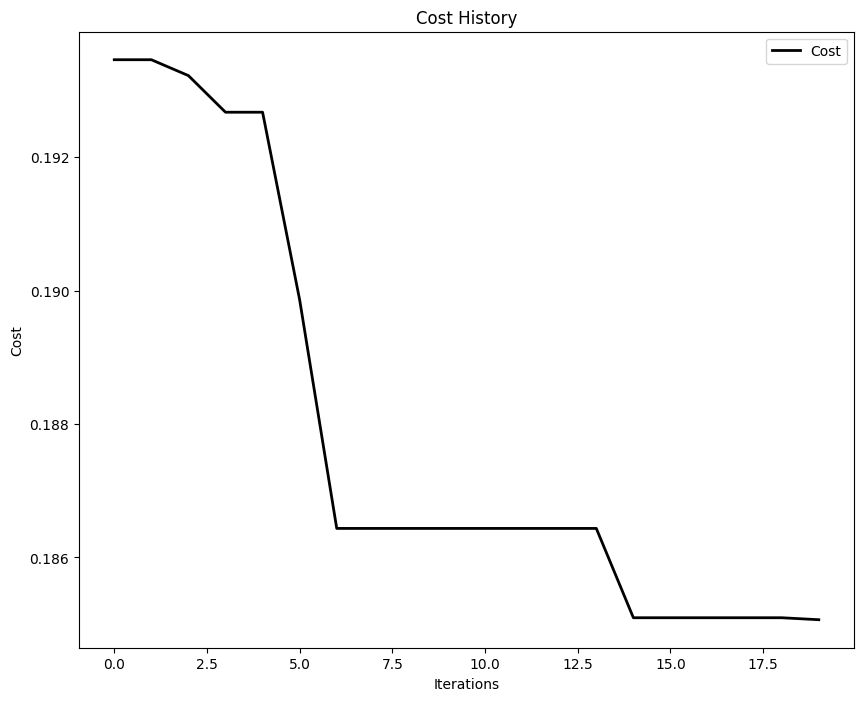

In [37]:
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
# plot loss history
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

In [41]:
# mech 3
Sign_in = [in_Sing3]
# Simulieren des gesamtsystems
konst =  {'mf1_m3': 1e-03, 'mf2_m3': 1e-03, 'm_m3': 5.43865529e-03, 'k11_m3': 7.87593750e+02, 'k12_m3': 7.87593750e+02, 'k21_m3': 8.37593750e+02, 'k22_m3': 8.37593750e+02, 'd11_m3': 2.96875000e+00, 'd12_m3': 2.96875000e+00, 'd21_m3': 1.70312500, 'd22_m3': 1.70312500, 'dv1_m3': 2.71093750, 'dv2_m3': 2.98437500} | {'F_Hydr_m3':0}
input = (F_Mag_m3,)

abh = None#[[fun_Mhyst1,d2_r2,p1_r2],[fun_Mhyst2,d3_r2,p1_r2]]

t_eval = (0, df3['Time'].iat[-1], len(df3['Time']))

solution = Simulate(Cb,konst, input,Sign_in, [0,0,0,0,0,0],(0,df3['Time'].iat[-1]),t_eval,abh,'BDF')


trace1 = go.Scatter(x=df3['Time'].values, y= df3['Position'].values, mode='lines', name='Position Messdaten')
trace2 = go.Scatter(x=solution.t, y= solution.y[3], mode='lines', name='Position Model')

layout = go.Layout(title='Vergleich Modell Messdaten',
                   xaxis=dict(title='Zeit'),
                   yaxis=dict(title='Wert'))

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [39]:
Sign_in = [in_Sing]
# Simulieren des gesamtsystems
konst =  {'mf1_m3': 1e-03, 'mf2_m3': 1e-03, 'm_m3': 5.43865529e-03, 'k11_m3': 7.87593750e+02, 'k12_m3': 7.87593750e+02, 'k21_m3': 8.37593750e+02, 'k22_m3': 8.37593750e+02, 'd11_m3': 2.96875000e+00, 'd12_m3': 2.96875000e+00, 'd21_m3': 1.70312500, 'd22_m3': 1.70312500, 'dv1_m3': 3.71093750, 'dv2_m3': 3.98437500} | {'F_Hydr_m3':0}
input = (F_Mag_m3,)

abh = None#[[fun_Mhyst1,d2_r2,p1_r2],[fun_Mhyst2,d3_r2,p1_r2]]

t_eval = (0, df2['Time'].iat[-1], len(df2['Time']))

solution = Simulate(Cb,konst, input,Sign_in, [0,0,0,0,0,0],(0,df2['Time'].iat[-1]),t_eval,abh,'BDF')


trace1 = go.Scatter(x=df2['Time'].values, y= df2['Position'].values, mode='lines', name='Position Messdaten')
trace2 = go.Scatter(x=solution.t, y= solution.y[1], mode='lines', name='Position Model')

layout = go.Layout(title='Vergleich Modell Messdaten',
                   xaxis=dict(title='Zeit'),
                   yaxis=dict(title='Wert'))

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [25]:
# mech 1
Sign_in = [in_Sing3]
# Simulieren des gesamtsystems
konst =  {'d': 3.115, 'k': 844, 'm': 2.22e-3} | {'F_Hydr':0}
input = (F_Mag,)

abh = None#[[fun_Mhyst1,d2_r2,p1_r2],[fun_Mhyst2,d3_r2,p1_r2]]

t_eval = (0, df3['Time'].iat[-1], len(df3['Time']))

solution = Simulate(Cb,konst, input,Sign_in, [0,0],(0,df3['Time'].iat[-1]),t_eval,abh,'BDF')


trace1 = go.Scatter(x=df3['Time'].values, y= df3['Position'].values, mode='lines', name='Position Messdaten')
trace2 = go.Scatter(x=solution.t, y= solution.y[1], mode='lines', name='Position Model')

layout = go.Layout(title='Vergleich Modell Messdaten',
                   xaxis=dict(title='Zeit'),
                   yaxis=dict(title='Wert'))

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [29]:
Sign_in = [in_Sing]
# Simulieren des gesamtsystems
konst =  {'d': 3.115, 'k': 844, 'm': 2.22e-3} | {'F_Hydr':0}
input = (F_Mag,)

abh = None#[[fun_Mhyst1,d2_r2,p1_r2],[fun_Mhyst2,d3_r2,p1_r2]]

t_eval = (0, df2['Time'].iat[-1], len(df2['Time']))

solution = Simulate(Cb,konst, input,Sign_in, [0,0],(0,df2['Time'].iat[-1]),t_eval,abh,'BDF')


trace1 = go.Scatter(x=df2['Time'].values, y= df2['Position'].values, mode='lines', name='Position Messdaten')
trace2 = go.Scatter(x=solution.t, y= solution.y[1], mode='lines', name='Position Model')

layout = go.Layout(title='Vergleich Modell Messdaten',
                   xaxis=dict(title='Zeit'),
                   yaxis=dict(title='Wert'))

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

# Test daten

In [ ]:

#Eingangssignal
Sign_in = [input_signal2]#[input_signal, input_signal2]


#------------------
# Simulieren des gesamtsystems
konst =  {'F_Hydr':0, 'd': 20, 'k':800, 'm':0.005}
input = (F_Mag,)

abh = None#[[fun_hyst1,R_H1,q],[fun_hyst2,R_H2,q]]

t_eval = (0, 20, 10000)

solution = Simulate(Cb,konst, input,Sign_in, [0,0],(0,20),t_eval,abh,'BDF')


real_t = solution.t
real_p = solution.y[0]
real_q = solution.y[1]

In [ ]:

Sign_in = [input_signal2]

def cost_function(param):

    a = param[:,0].tolist()
    b = param[:,1].tolist()
    d = param[:,2].tolist()
    #e = param[:,3].tolist()
    #f = param[:,4].tolist()
    c = np.zeros([1,len(param[:,1])])

    for i in range(len(param[:,1])):
        # Simulieren des gesamtsystems
        ai = b[i]
        bi = a[i]
        di = d[i]
        #ei = e[i]
        #fi = f[i]


        konst = {'F_Hydr':0, 'd': ai, 'k':bi, 'm':di}
        input = (F_Mag,)

        abh = None#[[fun_hyst1,R_Hyst1,Q_H1/C_H1],[fun_hyst2,R_Hyst2,Q_H2/C_H2]]

        t_eval = (0,20,10000)#(0, df3['Time'].iat[-1], len(downsampled))

        solution = Simulate(Cb,konst, input,Sign_in, [0,0],(0,20),t_eval,abh,'BDF')

        '''c[i,0] = np.array(sum((real_p - solution.y[0])**2)) #np.array([[sum((real_p - solution.y[0])**2)+ sum((real_q - solution.y[1])**2)]])
        c[i,1] = np.array(sum((real_q - solution.y[1])**2))'''

        c[0,i] = np.linalg.norm(input_signal2(np.linspace(0,20,10000)) - solution.y[1], ord=2) # normalized error
        #c[0,i] = sum((real_q - solution.y[1])**2) # quadratic error
        #c[0,i] = 1/len(param[:,1]) *  sum((real_q - solution.y[1])**2)  # Mean square Error
        #c[0,i] = sum( ( ( real_q - solution.y[1] )**2 )**0.5 ) # Euclidean distance


    return c[0] #np.sum(c, axis=0)

#mech
max_bound = [10, 850,0.01]
min_bound = [0.5, 500, 0.001]


bounds = (min_bound, max_bound)




In [ ]:

# Set-up hyperparameters
options = {'c1': 4.87533413838095, 'c2': 0.9359246862963, 'w': 4.4657253415724405, 'k': 13, 'p': 2}#{'c1': 0.5, 'c2': 0.4, 'w':0.3}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=30, dimensions=3, options=options,bounds=bounds, oh_strategy={"w":'exp_decay', 'c1':'lin_variation'})

# Perform optimization
cost, pos = optimizer.optimize(cost_function, iters=10)

2024-01-31 14:25:40,453 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 4.87533413838095, 'c2': 0.9359246862963, 'w': 4.4657253415724405, 'k': 13, 'p': 2}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=57.8
2024-01-31 14:30:42,278 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 57.81703802027699, best pos: [9.99002418e+00 5.40907948e+02 2.21393683e-03]


In [ ]:
from pyswarms.utils.search.random_search import RandomSearch

In [ ]:
%%time
options = {'c1': [0.2, 5],
               'c2': [0.2, 10],
               'w' : [0.2, 5],
               'k' : [1, 15],
               'p' : 2}
g = RandomSearch(ps.single.LocalBestPSO, n_particles=50, dimensions=3,
                   options=options, objective_func=cost_function, iters=10,n_selection_iters=3,bounds=bounds)

best_score, best_options = g.search()

2024-01-31 13:52:22,528 - pyswarms.single.local_best - INFO - Optimize for 10 iters with {'c1': 4.87533413838095, 'c2': 0.9359246862963, 'w': 4.4657253415724405, 'k': 13, 'p': 2}
pyswarms.single.local_best: 100%|██████████|10/10, best_cost=57.8
2024-01-31 14:01:50,250 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 57.81703468866729, best pos: [9.39921777e+00 5.27093406e+02 9.27966196e-03]
2024-01-31 14:01:50,261 - pyswarms.single.local_best - INFO - Optimize for 10 iters with {'c1': 3.6459855616501273, 'c2': 3.1138220634275027, 'w': 2.098382489079303, 'k': 3, 'p': 2}
pyswarms.single.local_best: 100%|██████████|10/10, best_cost=57.8
2024-01-31 14:10:07,100 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 57.81703993033601, best pos: [9.69883495e+00 5.58442797e+02 2.29712930e-03]
2024-01-31 14:10:07,111 - pyswarms.single.local_best - INFO - Optimize for 10 iters with {'c1': 3.414846972755158, 'c2': 1.866492122415199, 'w': 1.93387752900906

CPU times: user 22min 13s, sys: 4.95 s, total: 22min 18s
Wall time: 26min 6s


In [ ]:
best_options

{'c1': 4.87533413838095,
 'c2': 0.9359246862963,
 'w': 4.4657253415724405,
 'k': 13,
 'p': 2}